# **GeoSpy API:** Image Geo-localization and Classification

This notebook is a simple example of how to use the GeoSpy API to classify and geolocalize images. The API is a RESTful web service that allows you to send images and receive the classification and geolocalization of the image. 


## Installation

In [300]:
!pip install -q folium
!pip install -q scikit-learn
!pip install -q matplotlib
!pip install -q aiohttp
!pip install -q asyncio
!pip install -q pillow
!pip install -q geopy

In [1]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

 ## Load An Image 🌃 

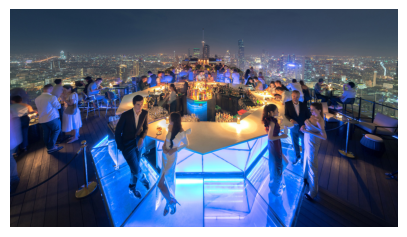

In [2]:
uploaded = "sample_images/bar.jpg"
image_path = uploaded
    
def load_image(image_path):
    if uploaded:
        
            image = Image.open(image_path)
            plt.figure(figsize=(5, 5))
            plt.imshow(image)
            plt.axis('off')
            plt.show()
    else:
        print("No image uploaded. Please try again.")

load_image(image_path)


In [3]:
import aiohttp
import asyncio
import base64
import folium
from aiohttp import ClientTimeout
import nest_asyncio
nest_asyncio.apply()

## Define an async function to send the image to the API 📷

In [46]:
async def fetch_geolocation(image_path, top_k=5 ,use_classification=False, anti_cluster=False):
    BASE_URL = "https://dev.geospy.ai"  # The GeoSpy API base URL
    ROUTE = "/predict"           # The GeoSpy API route
    API_KEY = "YOUR_API_KEY"  # Replace with your actual API key
    URL = BASE_URL + ROUTE # The complete URL
    
    # Note the supported image types are: jpeg, jpg, png, and webp
    async with aiohttp.ClientSession() as session:
        with open(image_path, "rb") as image_file:
            b64_image = base64.b64encode(image_file.read()).decode("utf-8")

        payload = {
            "image": b64_image,
            "top_k": top_k,  # Number of results to return
        }
        
        headers = {'Content-Type': 'application/json',
                   'Authorization': f"Bearer {API_KEY}"}
        timeout = ClientTimeout(total=90)
        
        async with session.post(URL, json=payload, headers=headers, timeout=timeout) as response:
            if response.status == 200:
                return await response.json()
            else:
                print(f"Failed to fetch geolocation, status code: {response.status}")
                return None
            

## Encode the image and send it to the API 📞

In [47]:
# if this is the first time calling the api, it may take 30-60 seconds to load the model
response = await fetch_geolocation(image_path, top_k=50)
response

{'status': 200,
 'message': 'Success',
 'geo_predictions': [{'coordinates': [13.72344970703125, 100.53968811035156],
   'score': 0.018296463415026665,
   'similarity_score_1km': 0.9145172307546643},
  {'coordinates': [13.724499702453613, 100.54000091552734],
   'score': 0.01827954687178135,
   'similarity_score_1km': 0.9136716864583856},
  {'coordinates': [13.72487735748291, 100.54157257080078],
   'score': 0.018260624259710312,
   'similarity_score_1km': 0.9127258722648274},
  {'coordinates': [13.721040725708008, 100.52730560302734],
   'score': 0.01798492670059204,
   'similarity_score_1km': 0.8989456043206088},
  {'coordinates': [13.72313117980957, 100.51982879638672],
   'score': 0.016850670799613,
   'similarity_score_1km': 0.842251775464122},
  {'coordinates': [13.720256805419922, 100.53356170654297],
   'score': 0.016745388507843018,
   'similarity_score_1km': 0.8369894213286276},
  {'coordinates': [13.72421932220459, 100.52288055419922],
   'score': 0.016710514202713966,
   'si

# Response 📬

```json
{
 "status": 200,
 "message": "Success",
 "geo_predictions": 
 [
    {
      "coordinates": [13.72344970703125, 100.53968811035156],"score": 0.018296463415026665, "similarity_score_1km": 0.97
    },
  ]
}

```

So what does this mean? The API has returned a list of coordinates and scores. The coordinates are the latitude and longitude of the image. The score is how closely the features of the image match the features of the coordinates. Scores should not necessarily be compared between images, but they can be used to compare the quality of the predictions for a single image. Similarity score 1km is a measure of how similar the image is to the features of the coordinates within 1km of the featured coordinates.

## Visualize the results on a map 🗺️

In [40]:
import folium
from folium.plugins import HeatMap

# Extract the gps predictions
predictions = response['geo_predictions']

# Extract probabilities and GPS coordinates
probabilities = [prediction['similarity_score_1km'] for prediction in predictions]
gps_coordinates = [prediction['coordinates'] for prediction in predictions]

# Combine coordinates with similarity scores, adjusting for visualization
weighted_coordinates = [(coord[0], coord[1], score*100) for coord, score in zip(gps_coordinates, probabilities)]

# Calculate the average location to center the map
avg_lat = sum(lat for lat, _, _ in weighted_coordinates) / len(weighted_coordinates)
avg_lon = sum(lon for _, lon, _ in weighted_coordinates) / len(weighted_coordinates)

# Create a map centered around the average coordinates
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=14)  # Adjust zoom level as needed

# Add a heat map layer to the map with adjusted scores
HeatMap(weighted_coordinates, radius=15).add_to(m)

# Mark the top coordinate based on similarity score
top_index = probabilities.index(max(probabilities))
top_coordinate = gps_coordinates[top_index]
top_adjusted_score = probabilities[top_index] * 100  # Convert to percentage for readability

folium.Marker(
    location=top_coordinate,
    popup=f"Top Prediction: {top_coordinate}\nScore: {top_adjusted_score:.2f}%",
    icon=folium.Icon(color='red', icon='star')
).add_to(m)


# Display the map
m
